In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using LsqFit, Optim
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [2]:
tdata = [range(0, 12 , step=1.0);]
tend = tdata[end]
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')'

13×10 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 4.18551  3.99136  3.49136  3.29788     3.49136  4.00515  3.49136  4.50515
 5.67816  5.47712  5.44716  5.77233     5.7954   6.03148  6.18551  6.17215
 6.00515  5.84488  5.81012  6.24612     5.74951  5.83815  5.78784  6.03148
 5.9364   5.82436  5.83815  5.49136     6.03148  6.26036  5.59921  5.49136
 5.97712  5.81012  5.78016  5.9624   …  5.82436  6.1294   5.97712  5.34242
 5.44716  5.0874   5.2954   5.14412     5.2954   5.18551  5.34488  5.81012
 5.19848  4.49136  5.01851  5.51851     5.17215  4.83815  5.47712  5.01188
 4.00515  0.0      2.94716  3.23882     3.26036  0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0    

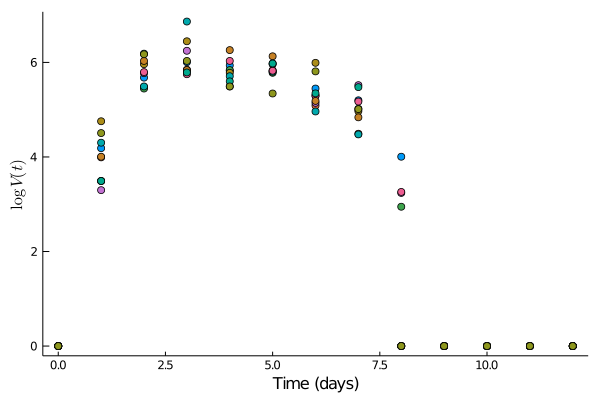

In [3]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[:, i], seriestype=:scatter) for i in 1:size(data, 2)]
plt

### Average of data

In [4]:
vdata_avg = mean(data, dims=2)[:]
vdata_std = std(data, dims=2)[:];

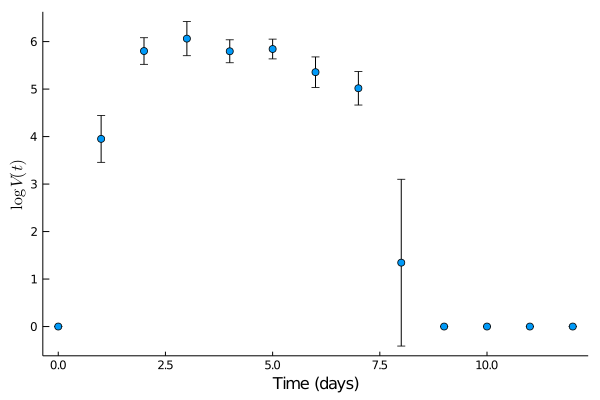

In [5]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [6]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
vvdata = reshape(data', 1, :)[:];

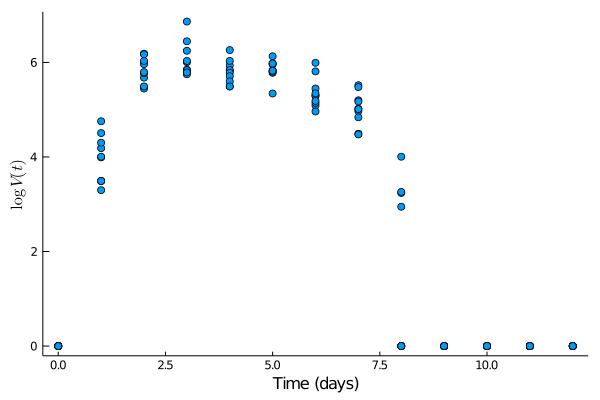

In [7]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## ODE Model


The standard kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [8]:
# function viral_target!(du, u, pars, t)
#     T, I₁, I₂, V = u
#     β, k, δ, K, p, c = pars
#     du[1] = dT = -β*T*V
#     du[2] = dI₁ = β*T*V - k*I₁
#     du[3] = dI₂ = k*I₁ - δ*I₂/(K + I₂)
#     du[4] = dV = p*I₂ - c*V
# end
viral_target = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;

In [9]:
u0 = [1e+7, 75.0, 0.0, 1e-14]
tspan = (0.0, tend)
pars = (β = 9.9e-5,
        k = 4.0,
        δ = 1.65e+6,
        K = 1.134e+5,
        p = 1.7,
        c = 12.48)
prob = ODEProblem(viral_target, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 12.0)
u0: [1.0e7, 75.0, 0.0, 1.0e-14]

In [10]:
sol = solve(prob, Tsit5(); dtmax=1e-2);

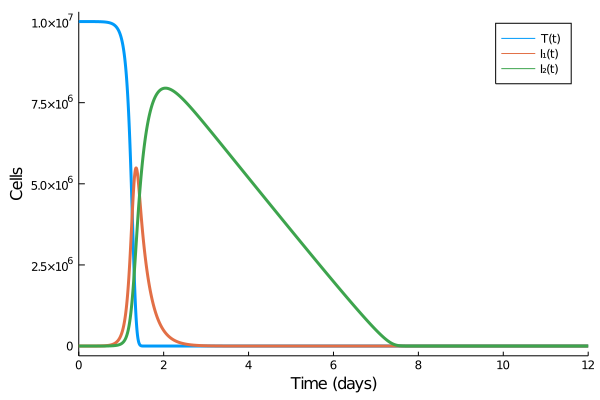

In [11]:
plot(sol, vars=(1:3), lw=3, xlabel="Time (days)", ylabel="Cells", grid=:off)

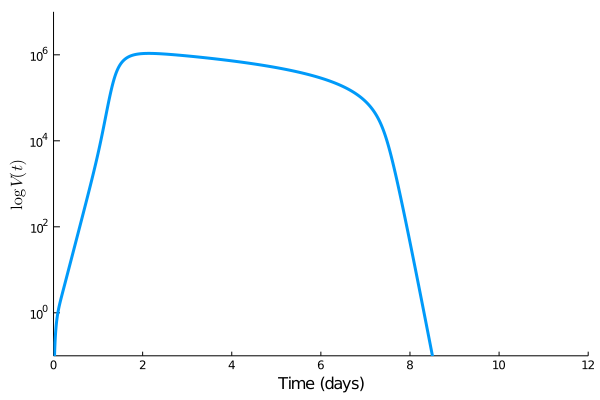

In [12]:
plot(sol, vars=(4), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (1e-1, 1e+7), :log10))

In [13]:
minimum(sol[end, :])

1.0e-14

### Fitting the ODE model to data

Only $V$ in logarithmic scale to fit the model.

Problem: V becomes negative for large $t$. What should we do?

In [34]:
function model(t, p)
    pars = (β = p[1],
            k = p[2],
            δ = p[3],
            K = p[4],
            p = p[5],
            c = p[6])
    prob = ODEProblem(viral_target, u0, tspan, pars)
    sol = solve(prob, Tsit5())
    # log10.(sol(t)[end, :])
    # TODO: fix negative numbers
    log10.(max.(sol(t)[end, :], 1e-15))
end

model (generic function with 1 method)

In [35]:
# par0 = (β = 9.9e-5,
#         k = 4.0,
#         δ = 1.65e+6,
#         K = 1.134e+5,
#         p = 1.7,
#         c = 12.48)
par0 = [9.9e-5,
        4.0,
        1.65e+6,
        1.13e+5,
        1.7,
        12.4]
fit = curve_fit(model, ttdata, vvdata, par0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([9.829967216635699e-5, 4.0014103282822555, 1.6499099516794798e6, 112967.22283942945, 1.7000765322643498, 12.3994661241977], [-14.0, -14.0, -14.0, -14.0, -14.0, -14.0, -14.0, -14.0, -14.0, -14.0  …  -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

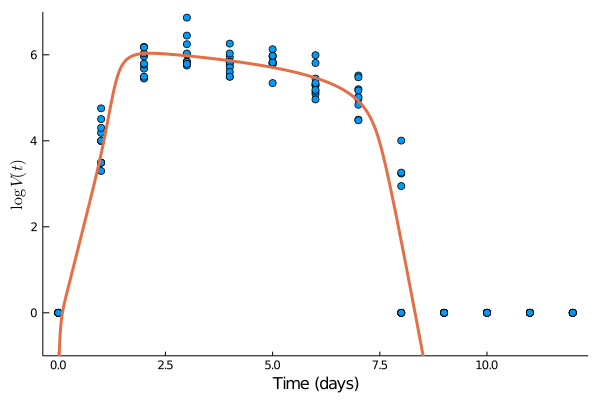

In [24]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
plot!(tt, model(tt, fit.param), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [25]:
par0

6-element Array{Float64,1}:
      9.9e-5
      4.0
      1.65e6
 113000.0
      1.7
     12.4

In [26]:
fit.param

6-element Array{Float64,1}:
      9.829967216635699e-5
      4.0014103282822555
      1.6499099516794798e6
 112967.22283942945
      1.7000765322643498
     12.3994661241977

In [27]:
confidence_interval(fit, 0.1)

6-element Array{Tuple{Float64,Float64},1}:
 (5.177078994750484e-5, 0.00014482855438520913)
 (-64.7353976237872, 72.73821828035172)
 (-667507.1384867304, 3.96732704184569e6)
 (-1.4864248234712353e6, 1.7123592691500944e6)
 (-11.04841576440525, 14.448568828933949)
 (-25.477462616679446, 50.27639486507485)

In [28]:
sum(fit.resid.^2)

5536.102503619151

In [29]:
stderror(fit)

6-element Array{Float64,1}:
      2.8076213124212e-5
     41.476802740780336
      1.398363618862857e6
 965096.7274514416
      7.692628098180447
     22.85549691087534

## Standard viral function

Now consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{\max - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - \min}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.




In [136]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, max) = 1. + (max - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, min) = 1. - (1.0 - min)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function ViralLoad(t, par) 
    a₁, a₂, b₁, b₂, α, mini, maxi = par
#     log10.(v₁.(t, a₁, a₂, maxi).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, mini))
    # TODO: fix negative numbers
    log10.(max.(v₁.(t, a₁, a₂, maxi).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, mini), 1e-15))
end

ViralLoad (generic function with 1 method)

In [137]:
function LossFunction(p)
#     par = vcat(p, [7e-12, 9e5])
    sum(abs2, ViralLoad(ttdata, p) - vvdata)
end

LossFunction (generic function with 1 method)

In [138]:
par0 = [0.7, 2.8, 6.2, 7.6, 0.2, 7e-06, 9e+05]
LossFunction(par0)

37.457058809748595

In [144]:
par0 = [1.0, 2.3, 6.0, 8.5, 0.5, 1e-6, 1.5e6]
lower = [0.0, 0.0, 0.0, 0.0, 1e-10, 1e-12, 1e2]
upper = [12.0, 12.0, 12.0, 12., 1.0, 1e2, 1e7]
inner_optimizer = ConjugateGradient()
result = optimize(LossFunction, lower, upper, par0, Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Final objective value:     3.683973e+01

 * Found with
    Algorithm:     Fminbox with Conjugate Gradient

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.02e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    6
    f(x) calls:    51597
    ∇f(x) calls:   50793


In [140]:
Optim.minimizer(result)

7-element Array{Float64,1}:
 0.7739527508364107
 2.989668152240988
 6.313123567967991
 7.668586704036664
 0.39485390299011064
 1.9316583706596956e-5
 1.0578419054800936e6

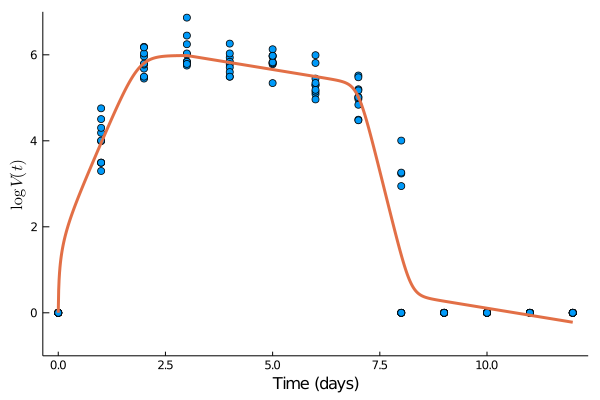

In [135]:
tt = [range(0., tend, step=1e-2);]
vv = ViralLoad(tt, Optim.minimizer(result))
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [40]:
fit2 = curve_fit(logV, ttdata, vvdata, par0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7405579049804155, 2.882552799628832, 6.226098236207015, 7.605851411822182, 0.23853437695695662, 7.194378848432214e-6, 855307.4778730464], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372, -0.1554157354468372], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0001280924155399406 0.10356125537519056 … 87996.32851614452 5.077641586547211e-7; 0.0001280924155399406 0.10356125537519056 … 87996.32851614452 5.077641586547211e-7], true, Float64[])

In [77]:
sum(abs2, fit2.resid)

36.34237700025548

In [41]:
fit2.param

7-element Array{Float64,1}:
      0.7405579049804155
      2.882552799628832
      6.226098236207015
      7.605851411822182
      0.23853437695695662
      7.194378848432214e-6
 855307.4778730464

In [43]:
confidence_interval(fit2, 0.1)

7-element Array{Tuple{Float64,Float64},1}:
 (0.5429308562084758, 0.9381849537523552)
 (2.081983139291153, 3.683122459966511)
 (5.9874112553268715, 6.464785217087159)
 (7.4887840932968786, 7.7229187303474855)
 (0.030077577928919574, 0.44699117598499366)
 (6.059943611832488e-7, 1.378276333568118e-5)
 (510504.141641505, 1.2001108141045878e6)

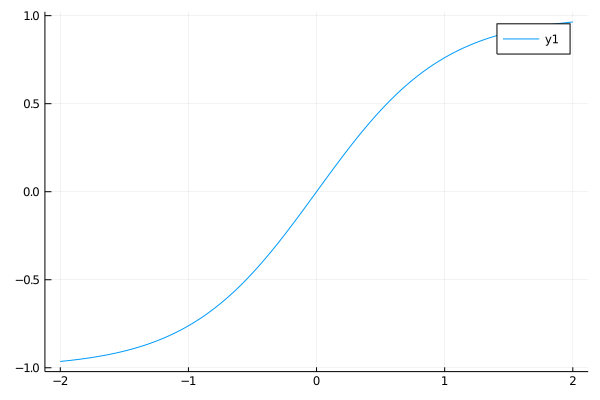

In [142]:
tt = Array(range(-2, 2, length=100))
plot(tt, tanh.(tt))

In [44]:
using Optim
f(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2

f (generic function with 1 method)

In [45]:
x0 = [0.0, 0.0]
optimize(f, x0)

 * Status: success

 * Candidate solution
    Final objective value:     3.525527e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    60
    f(x) calls:    118


In [57]:
function g!(G, x)
G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
G[2] = 200.0 * (x[2] - x[1]^2)
end

g! (generic function with 1 method)

In [79]:
lower = [1.25, -2.1]
upper = [Inf, Inf]
initial_x = [2.0, 2.0]
inner_optimizer = LBFGS()
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))

 * Status: success

 * Candidate solution
    Final objective value:     6.250000e-02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 6.83e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.41e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.54e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    124
    ∇f(x) calls:   124


In [69]:
Optim.minimizer(results)

2-element Array{Float64,1}:
 1.2500000000000002
 1.5626548683420372